In [1]:
import pandas as pd
import os, errno
import time
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [2]:
meta_data = pd.read_csv('~/vox1_meta.csv', sep='\t')

In [3]:
#print(meta_data["Nationality"].value_counts())
# print(meta_data["Gender"].value_counts())

In [4]:
# meta_data

In [5]:
# @brief Get speaker IDs where their metadata value for keys[i] has value values[i]
# @param alt_map Instead of comparing the key to value, compare map[key] to value
def get_ids(data, keys, values):
    for key_idx, value in enumerate(values):
        # set data to subset with value for given key
        data = data[data[keys[key_idx]] == value]
        
    return set(data['VoxCeleb1 ID'])

# @brief Return list of tuples of all combinations of keys in
#        the sensitive param provided as args
def get_intersection_combos(*sensitive_param_value_groups):
    return list(itertools.product(*sensitive_param_value_groups))

def map_col(df, key, values_map):
    return df.replace({key: values_map})

def plot_sample_distribution(sample_dist, title, save_path, width):
    fig, axs = plt.subplots(len(sample_dist))
    fig.set_size_inches(width, 5)
    fig.suptitle(title)
    m_f_map = {'m':"Male", 'f': "Female"}
    
    for i, (key, _) in enumerate(sample_dist.items()):
        max_display = 20
        data = sample_dist[key]['data']
        keys = sample_dist[key]['keys']
        axs[i].bar(keys,data)#, align='edge', width=2)

        axs[i].xaxis.set_ticklabels([])
        axs[i].set_ylim([0,max_display])
        axs[i].set(ylabel=m_f_map[key])
        
        # label with values
        for j, v in enumerate(data):
            axs[i].text(j-.25, min(max_display + 1, v + 1), str(v), color='blue')#, fontweight='bold')
        
    plt.xticks(range(len(sample_dist['m']['keys'])), sample_dist['m']['keys'], rotation=60)
    plot_name = title.replace('-', '_').replace('/', '_').replace(' ', '_')
    
    plt.savefig(os.path.join(save_path, plot_name))
    plt.show()

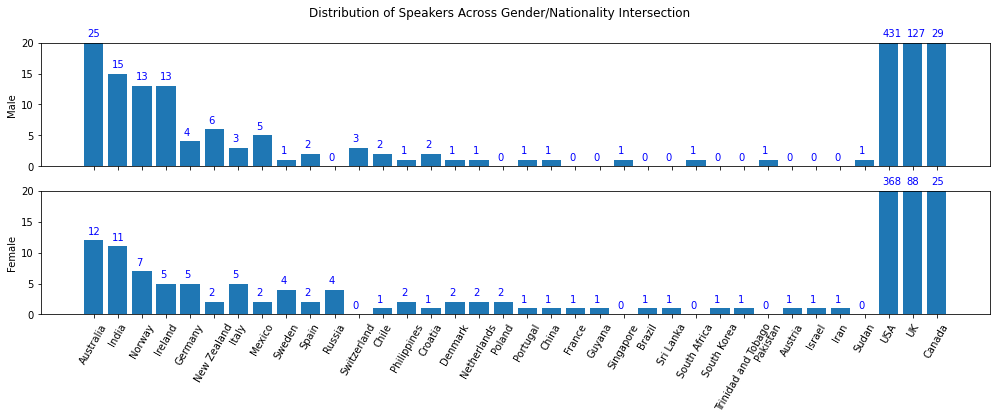

In [6]:
gender_values = ['m', 'f']
country_values = ['Australia', 'India', 'Norway', 'Ireland', 'Germany', 'New Zealand', 'Italy','Mexico',\
                  'Sweden', 'Spain', 'Russia', 'Switzerland', 'Chile', 'Philippines', 'Croatia', 'Denmark',\
                  'Netherlands', 'Poland', 'Portugal', 'China', 'France', 'Guyana', 'Singapore', 'Brazil',\
                  'Sri Lanka', 'South Africa', 'South Korea', 'Trinidad and Tobago', 'Pakistan', 'Austria',\
                  'Israel', 'Iran', 'Sudan', 'USA', 'UK', 'Canada']

native_lang_map = {'Australia': 'english', 'India': 'non-english', 'Norway': 'non-english', 'Ireland': 'english', 'Germany': 'non-english', 'New Zealand': 'english', 'Italy': 'non-english','Mexico': 'non-english',\
                  'Sweden': 'non-english', 'Spain': 'non-english', 'Russia': 'non-english', 'Switzerland': 'non-english', 'Chile': 'non-english', 'Philippines': 'non-english', 'Croatia': 'non-english', 'Denmark': 'non-english',\
                  'Netherlands': 'non-english', 'Poland': 'non-english', 'Portugal': 'non-english', 'China': 'non-english', 'France': 'non-english', 'Guyana': 'non-english', 'Singapore': 'non-english', 'Brazil': 'non-english',\
                  'Sri Lanka': 'non-english', 'South Africa': 'non-english', 'South Korea': 'non-english', 'Trinidad and Tobago': 'non-english', 'Pakistan': 'non-english', 'Austria': 'non-english',\
                  'Israel': 'non-english', 'Iran': 'non-english', 'Sudan': 'non-english', 'USA': 'english', 'UK': 'english', 'Canada': 'english'}
native_lang_values = list(set(native_lang_map.values()))

native_lang_map_full = {'Australia': 'English', 'India': 'Hindi', 'Norway': 'Norwegian', 'Ireland': 'English', 'Germany': 'German', 'New Zealand': 'English', 'Italy': 'Italian','Mexico': 'Spanish',\
                  'Sweden': 'Swedish', 'Spain': 'Spanish', 'Russia': 'Russian', 'Switzerland': 'Mixed', 'Chile': 'Spanish', 'Philippines': 'English', 'Croatia': 'Croatian', 'Denmark': 'Danish',\
                  'Netherlands': 'Dutch', 'Poland': 'Polish', 'Portugal': 'Portuguese', 'China': 'Mandarin', 'France': 'French', 'Guyana': 'English', 'Singapore': 'English', 'Brazil': 'Portuguese',\
                  'Sri Lanka': 'Sinhala', 'South Africa': 'Afrikaans', 'South Korea': 'Korean', 'Trinidad and Tobago': 'English', 'Pakistan': 'English', 'Austria': 'German',\
                  'Israel': 'Hebrew', 'Iran': 'Persian', 'Sudan': 'Arabic', 'USA': 'English', 'UK': 'English', 'Canada': 'English'}
native_lang_values_full = list(set(native_lang_map_full.values()))

keys = ['Gender', 'Nationality']
intersections_ids = []
do_intersection = "gender-nationality"
#do_intersection = "gender-native-lang"
#do_intersection = "gender-native-lang-full"
plot_save_path = "/home/jupyter/voxceleb-fairness/data/speaker-meta-data/"

if do_intersection == "gender-nationality":
    # GENDER/NATIONALITY intersection
    # get all combinations of sensitive param values
    intersections_vals = get_intersection_combos(gender_values, country_values)
    
    # track the distribution of speakers across the intersections for confidence info
    # on statistical significance
    n_speaker_dist = {'m': {'data': [], 'keys': []}, 'f': {'data': [], 'keys': []}}
    
    # get all speaker IDs matching the combinations of sensitive param values
    for intersection in intersections_vals:
        ids = get_ids(meta_data, keys, intersection)
        intersections_ids.append(ids)
        #print(f"Intersection {intersection}.count -> {len(intersections_ids[-1])}")
        n_speaker_dist[intersection[0]]['data'].append(len(ids))
        n_speaker_dist[intersection[0]]['keys'].append(intersection[1])
        
    plot_sample_distribution(n_speaker_dist,
                             "Distribution of Speakers Across Gender/Nationality Intersection",
                             plot_save_path, width=17)
elif do_intersection == "gender-native-lang":
    # GENDER/NATIVE-LANG intersection
    # replace nationality col with native-lang col
    filtered_meta_data = map_col(meta_data, 'Nationality', native_lang_map)
    
    # get all combinations of sensitive param values
    intersections_vals = get_intersection_combos(gender_values, native_lang_values)
    
    # track the distribution of speakers across the intersections for confidence info
    # on statistical significance
    n_speaker_dist = {'m': {'data': [], 'keys': []}, 'f': {'data': [], 'keys': []}}

    # get all speaker IDs matching the combinations of sensitive param values
    for intersection in intersections_vals:
        ids = get_ids(filtered_meta_data, keys, intersection)
        intersections_ids.append(ids)
        print(f"Intersection {intersection}.count -> {len(intersections_ids[-1])}")
        n_speaker_dist[intersection[0]]['data'].append(len(ids))
        n_speaker_dist[intersection[0]]['keys'].append(intersection[1])
        
    plot_sample_distribution(n_speaker_dist,
                             "Distribution of Speakers Across Gender/Native-Lang Intersection",
                             plot_save_path)
elif do_intersection == "gender-native-lang-full":
    # GENDER/NATIVE-LANG intersection
    # replace nationality col with native-lang col
    filtered_meta_data = map_col(meta_data, 'Nationality', native_lang_map_full)
    
    # get all combinations of sensitive param values
    intersections_vals = get_intersection_combos(gender_values, native_lang_values_full)
    
    # track the distribution of speakers across the intersections for confidence info
    # on statistical significance
    n_speaker_dist = {'m': {'data': [], 'keys': []}, 'f': {'data': [], 'keys': []}}

    # get all speaker IDs matching the combinations of sensitive param values
    for intersection in intersections_vals:
        ids = get_ids(filtered_meta_data, keys, intersection)
        status = ""
        if len(ids) >= 2:
            intersections_ids.append(ids)
        else:
            intersections_ids.append(None)
            status = "-- [skipped] "
        n_speaker_dist[intersection[0]]['data'].append(len(ids))
        n_speaker_dist[intersection[0]]['keys'].append(intersection[1])
        
    plot_sample_distribution(n_speaker_dist,
                             "Distribution of Speakers Across Gender/Native-Lang Intersection",
                             plot_save_path, width=10)

In [ ]:
# load all utternaces
utters = pd.read_csv('/home/jupyter/voxceleb-fairness/data/datasets/full/vox1_full_utterances.txt', header=None, sep=' ')
intersections_utters = []

# extract all utterance subsets
for idx, intersection_ids in enumerate(intersections_ids):
    if intersection_ids:
        intersection_utters = utters[[x in intersection_ids for x in utters[0]]]
        sample_len = min(len(intersection_utters), 5000)
        intersections_utters.append(intersection_utters.sample(sample_len).reset_index(drop=True))
    else:
        intersections_utters.append(None)
    # print(intersections_vals[idx])
    # print(intersections_utters[-1])

In [50]:
# create list files from utterance subset files

def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occurred
            
def make_pairs(utters_df, filename):
    silentremove(filename)
    start = time.time()
    current_iter_start = start
    for i in range(len(utters_df)):
        data = []
        for j in range(i + 1, len(utters_df)):
            num = 1 if utters_df[0][i] == utters_df[0][j] else 0
            data.append([num, utters_df[1][i], utters_df[1][j]])
        pd.DataFrame(data).to_csv(filename, mode='a', index=False, header=None, sep=' ')
        if i % 1000 == 0:
            current_iter_end = time.time()
            print('Wrote {} of {} utterances in {} seconds ({} seconds from start)'.format(i, len(utters_df), current_iter_end - current_iter_start, current_iter_end - start))
            current_iter_start = current_iter_end

def clean_intersection_name(name):
    name = name.replace(')','')
    name = name.replace('(','')
    name = name.replace('\'','')
    name = name.replace(' ','')
    name = name.replace(',','_')
    return name

In [51]:
# extract the full lists
list_fnames = []
for idx, intersection_utters in enumerate(intersections_utters):
    if intersection_utters is not None:
        # get file name for list and make dirs
        name = clean_intersection_name(str(intersections_vals[idx]))
        list_fnames.append(f"/home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_{name}.txt")
        os.makedirs(os.path.dirname(list_fnames[-1]), exist_ok=True)
        # write the list
        make_pairs(intersection_utters, list_fnames[-1])

Wrote 0 of 197 utterances in 0.021676063537597656 seconds (0.021676063537597656 seconds from start)
Wrote 0 of 202 utterances in 0.01659870147705078 seconds (0.01659870147705078 seconds from start)
Wrote 0 of 742 utterances in 0.043233633041381836 seconds (0.043233633041381836 seconds from start)
Wrote 0 of 1744 utterances in 0.09528255462646484 seconds (0.09528255462646484 seconds from start)
Wrote 1000 of 1744 utterances in 70.82899522781372 seconds (70.92427778244019 seconds from start)
Wrote 0 of 5000 utterances in 0.27794718742370605 seconds (0.27794718742370605 seconds from start)
Wrote 1000 of 5000 utterances in 254.6999740600586 seconds (254.9779212474823 seconds from start)
Wrote 2000 of 5000 utterances in 199.0095100402832 seconds (453.9874312877655 seconds from start)
Wrote 3000 of 5000 utterances in 141.56716990470886 seconds (595.5546011924744 seconds from start)
Wrote 4000 of 5000 utterances in 85.47222328186035 seconds (681.0268244743347 seconds from start)
Wrote 0 of 30

In [52]:
# create the balanced lists with equal positive and negative test pairs
def balance_pairs(unbalanced_pairs):
    return pd.concat([unbalanced_pairs[unbalanced_pairs[0] == 1].reset_index(drop=True),\
               unbalanced_pairs[unbalanced_pairs[0] == 0].sample(sum(unbalanced_pairs[0] == 1)).\
               reset_index(drop=True)]).sort_index().reset_index(drop=True)

for list_fname in list_fnames:
    try:
        print(f"Running {list_fname}")
        # set new file name
        new_fname = list_fname.replace('.txt', '_balanced.txt')
        # read in old data and etract balanced list
        pairs = pd.read_csv(list_fname, header=None, sep=' ')
        balanced_pairs = balance_pairs(pairs)
        # write the new list
        balanced_pairs.to_csv(new_fname, index=False, header=None, sep=' ')
    except ValueError:
        print(f">> File is empty... skipping")
    except FileNotFoundError:
        print(f">> File not found... skipping")

Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Croatian.txt
>> File is empty... skipping
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Italian.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_German.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Norwegian.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_English.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Hindi.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Spanish.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_m_Mixed.txt
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_f_Danish.txt
>> File is empty... skipping
Running /home/jupyter/voxceleb-fairness/data/lists/intersect/vox1_intersect_f_Italian.txt
Running /home/jupyter/voxceleb-fairness/data/